# Local and Global Differential Privacy

In [1]:
import sys
sys.path.append("..") # add parent directory to path
from common import *

In [2]:
import torch

## Project: Local Differential Privacy
As you can see, the basic sum query is not differentially private at all! In truth, differential privacy always requires a form of randomness added to the query. Let me show you what I mean.

### Randomized Response (Local Differential Privacy)
Let's say I have a group of people I wish to survey about a very taboo behavior which I think they will lie about (say, I want to know if they have ever committed a certain kind of crime). I'm not a policeman, I'm just trying to collect statistics to understand the higher level trend in society. So, how do we do this? One technique is to add randomness to each person's response by giving each person the following instructions (assuming I'm asking a simple yes/no question):

- Flip a coin 2 times.
- If the first coin flip is heads, answer honestly
- If the first coin flip is tails, answer according to the second coin flip (heads for yes, tails for no)!

Thus, each person is now protected with "plausible deniability". If they answer "Yes" to the question "have you committed X crime?", then it might becasue they actually did, or it might be becasue they are answering according to a random coin flip. Each person has a high degree of protection. Furthermore, we can recover the underlying statistics with some accuracy, as the "true statistics" are simply averaged with a 50% probability. Thus, if we collect a bunch of samples and it turns out that 60% of people answer yes, then we know that the TRUE distribution is actually centered around 70%, because 70% averaged wtih 50% (a coin flip) is 60% which is the result we obtained.

However, it should be noted that, especially when we only have a few samples, this comes at the cost of accuracy. This tradeoff exists across all of Differential Privacy. The greater the privacy protection (plausible deniability) the less accurate the results.

Let's implement this local DP for our database before!

In [3]:
def get_augment_db(db, noise=0.5):
    """
    Return an augmented db with the 2 coin flip strategy
    """
    p_head = 1 - noise
    noise_db = db.clone().float()
    num_entries = len(db)
    flip_no1 = (torch.rand(num_entries) < p_head).float()
    flip_no2 = (torch.rand(num_entries) < 0.5).float() # 2nd flip is always 50 50
    # if the first coin is head, answer honestly -> Keep db at indices where flip_no1 == 1
    # else, return the value of the second coin  -> Replace db at indices leftover
    # insort, we copy flip_no2 to db at indices where flip_no1 is tail
    noise_db[flip_no1 != 1] = flip_no2[flip_no1 != 1]
    return noise_db
    
    
def reverse_actual_percentage(augmented_percentage, noise=0.5) -> float:
    """
    Average the actual positive of the population, given the query result and
    probability of flipping a head (See more on README.md) 
    """
    p_head = 1 - noise
    return (augmented_percentage - (1 - p_head) * 0.5) / p_head
    

In [4]:
def query(db):
    return db.float().mean()

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
num_test = 1000
list_num_entries = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
mean_arr = []

for num_entries in list_num_entries:
    db = (torch.rand(int(num_entries)) > 0.5).float()
    actual_mean = torch.mean(db)
    differ = []
    for _ in range(num_test):
        aug_db = get_augment_db(db)
        aug_mean = reverse_actual_percentage(torch.mean(aug_db))
        d = torch.abs(aug_mean - actual_mean)
        differ.append(d.item())
    mean_arr.append(differ)
    

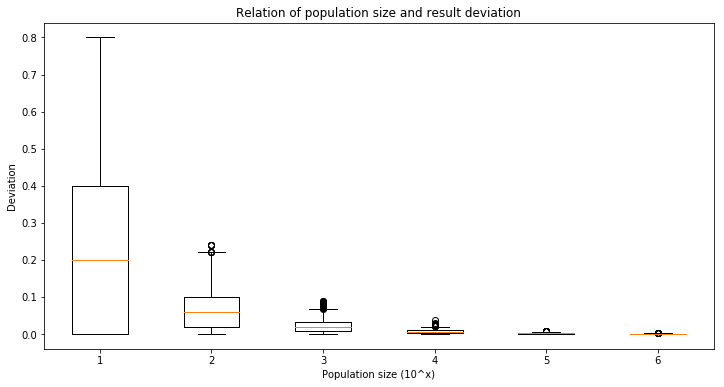

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Relation of population size and result deviation")
plt.boxplot(mean_arr)
plt.xlabel("Population size (10^x)")
plt.ylabel("Deviation")
# plt.savefig("relation1.png", dpi=200)
plt.show()

We can see that when the **population size increase**, Population's actual mean and augmented mean are getting **closer**

## Project: Varying Amounts of Noise
In this project, I want you to **augment the randomized response query** (the one we just wrote) to allow for varying amounts of randomness to be added. Specifically, I want you to **bias the first coin flip** to be higher or lower and then run the same experiment.

Note - this one is a bit tricker than you might expect. You need to both adjust the likelihood of the first coin flip AND the de-skewing at the end (where we create the "augmented_result" variable).

My code still work fine :D

In [8]:
def get_differ_distribution(num_entries, list_noise=[0.1, 0.3, 0.5, 0.7, 0.9]):
    """
    Generate List[List[float]] with each List[float] is the difference of actual mean and
    average mean which is calculated from augmented mean
    """
    # Generate DB
    db = (torch.rand(num_entries) > 0.5).float()
    actual_mean = query(db)
    result = []
    for noise in list_noise:
        query_differ = []
        for _ in range(num_test):
            aug_db = get_augment_db(db, noise)
            aug_mean = query(aug_db)
            aug_mean = reverse_actual_percentage(aug_mean, noise)
            query_differ.append(torch.abs(actual_mean - aug_mean).item())
        result.append(query_differ)
    return result

    
def plot_box(num_entries, result, list_noise):
#     plt.figure(figsize=(6, 10))
    plt.title(f"Relation of noise and deviation (N = {num_entries})")
    plt.boxplot(result)
    num_noise = len(list_noise)
    plt.xticks(ticks=range(1, num_noise + 1), labels=list_noise)
    plt.xlabel("Noise")
    plt.ylabel("Difference")


In [9]:
list_noise = [0.1, 0.3, 0.5, 0.7, 0.9]
num_entries = 1000
res1000 = get_differ_distribution(num_entries, list_noise)

In [10]:
list_noise = [0.1, 0.3, 0.5, 0.7, 0.9]
num_entries = 100000
res100000 = get_differ_distribution(num_entries, list_noise)

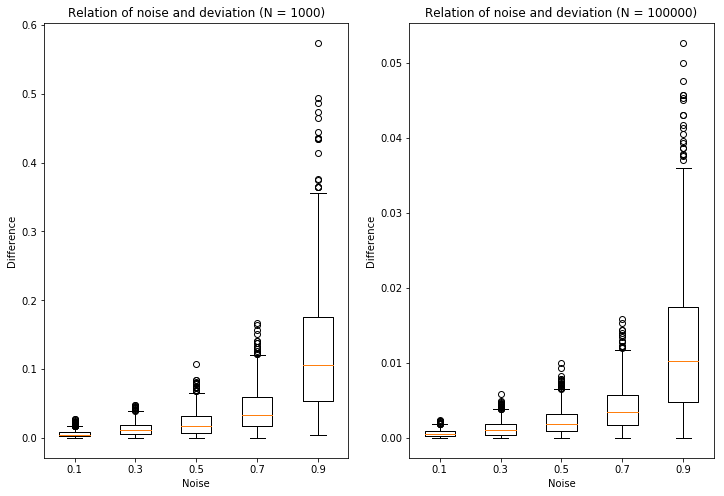

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plot_box(1000, res1000, list_noise)
plt.subplot(1, 2, 2)
plot_box(100000, res100000, list_noise)
# plt.savefig("relation2.png", dpi=200)
plt.show()

Beside the exponential increment of deviation when noise increase, we can see that when the population increase, the deviation is getting smaller. 

## Lesson: The Formal Definition of Differential Privacy
The previous method of adding noise was called "Local Differentail Privacy" because we added noise to each datapoint individually. This is necessary for some situations wherein the data is SO sensitive that individuals do not trust noise to be added later. However, it comes at a very high cost in terms of accuracy.

However, alternatively we can add noise **AFTER** data has been aggregated by a function. This kind of noise can allow for similar levels of protection with a **lower affect on accuracy**. However, participants must be able to **trust** that **no-one looked at their datapoints before the aggregation took place**. In some situations this works out well, in others (such as an individual hand-surveying a group of people), this is less realistic.

Nevertheless, global differential privacy is incredibly important because it allows us to perform differential privacy on smaller groups of individuals with lower amounts of noise. Let's revisit our sum functions.

In [12]:
db, pdbs = create_db_and_parallels(100)

def query(db):
    return torch.sum(db.float())

def M(db):
    query(db) + noise

query(db)

tensor(50.)

*Image From: "The Algorithmic Foundations of Differential Privacy" - Cynthia Dwork and Aaron Roth - https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf*

This definition does not create differential privacy, instead it is a measure of how much privacy is afforded by a query M. Specifically, it's a comparison between running the query M on a database (x) and a parallel database (y). As you remember, parallel databases are defined to be the same as a full database (x) with one entry/person removed.

Thus, this definition says that FOR ALL parallel databases, the maximum distance between a query on database (x) and the same query on database (y) will be e^epsilon, but that occasionally this constraint won't hold with probability delta. Thus, this theorem is called "epsilon delta" differential privacy.

### Epsilon
Let's unpack the intuition of this for a moment.

Epsilon Zero: If a query satisfied this inequality where epsilon was set to 0, then that would mean that the query for all parallel databases outputed the exact same value as the full database. As you may remember, when we calculated the "threshold" function, often the Sensitivity was 0. In that case, the epsilon also happened to be zero.

Epsilon One: If a query satisfied this inequality with epsilon 1, then the maximum distance between all queries would be 1 - or more precisely - the maximum distance between the two random distributions M(x) and M(y) is 1 (because all these queries have some amount of randomness in them, just like we observed in the last section).

### Delta
Delta is basically **the probability that epsilon breaks**. Namely, sometimes the epsilon is different for some queries than it is for others. For example, you may remember when we were calculating the sensitivity of threshold, most of the time sensitivity was 0 but sometimes it was 1. Thus, we could calculate this as "epsilon zero but non-zero delta" which would say that epsilon is perfect except for some probability of the time when it's arbitrarily higher. Note that this expression doesn't represent the full tradeoff between epsilon and delta.

## Lesson: How To Add Noise for Global Differential Privacy
In this lesson, we're going to learn about how to take a query and add varying amounts of noise so that it satisfies a certain degree of differential privacy. In particular, we're going to leave behind the Local Differential privacy previously discussed and instead opt to focus on Global differential privacy.

So, to sum up, this lesson is about adding noise to the output of our query so that it satisfies a certain epsilon-delta differential privacy threshold.

There are two kinds of noise we can add - Gaussian Noise or Laplacian Noise. Generally speaking Laplacian is better, but both are still valid. Now to the hard question...

### How much noise should we add?
The amount of noise necessary to add to the output of a query is a function of four things:
- The type of noise (Gaussian/Laplacian)
- The sensitivity of the query/function
- The desired epsilon (ε)
- The desired delta (δ)

Thus, for each type of noise we're adding, we have different way of calculating how much to add as a function of sensitivity, epsilon, and delta. We're going to focus on Laplacian noise. Laplacian noise is increased/decreased according to a "scale" parameter b. We choose "b" based on the following formula.

`b = sensitivity(query) / epsilon`

In other words, if we set b to be this value, then we know that we will have a **privacy leakage of <= epsilon**. Furthermore, the nice thing about Laplace is that it guarantees this with delta == 0. There are some tunings where we can have very low epsilon where delta is non-zero, but we'll ignore them for now.

### Querying Repeatedly
if we query the database multiple times - we can simply add the epsilons (Even if we change the amount of noise and their epsilons are not the same).

## Project: Create a Differentially Private Query
In this project, I want you to take what you learned in the previous lesson and create a query function which sums over the database and adds just the right amount of noise such that it satisfies an epsilon constraint. Write a query for both "sum" and for "mean". Ensure that you use the correct sensitivity measures for both.

In [13]:
import numpy as np

In [14]:
def sum_query(db):
    return db.float().sum().item()

def mean_query(db):
    return db.float().mean().item()

def laplacian_mechanism(db, query, sensitivity, epsilon):
    beta = sensitivity / epsilon
    noise = np.random.laplace(0, beta, size=1)[0]
    return query(db) + noise


We already know that sensitivity of `sum` is `1` 

In [15]:
num_entries = 1000
SUM_SENSITIVITY = 1.
MEAN_SENSITIVITY = 1./ num_entries

In [16]:
db, pdbs = create_db_and_parallels(num_entries=num_entries)

In [17]:
def query_repeat(db, query, sensitivity, epsilon, num_try= 1000):
    return [laplacian_mechanism(db, query, sensitivity, epsilon) for _ in range(num_try)]

In [18]:
def plot_distribution(epsilon):
    augmented_sum_results = query_repeat(db, sum_query, SUM_SENSITIVITY, epsilon, 1000)
    augmented_mean_results = query_repeat(db, mean_query, MEAN_SENSITIVITY, epsilon, 1000)
    
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.hist(augmented_sum_results, bins=20, ec='k')
    plt.axvline(sum_query(db), color='k', linestyle='dashed', linewidth=1, label='actual sum')
    plt.legend()
    plt.title(f"Sum query, epsilon = {epsilon}")

    plt.subplot(1, 2, 2)
    plt.hist(augmented_mean_results, bins=20, ec='k')
    plt.axvline(mean_query(db), color='k', linestyle='dashed', linewidth=1, label='actual mean')
    plt.legend()
    plt.title(f"Mean query, epsilon = {epsilon}")
    plt.show()

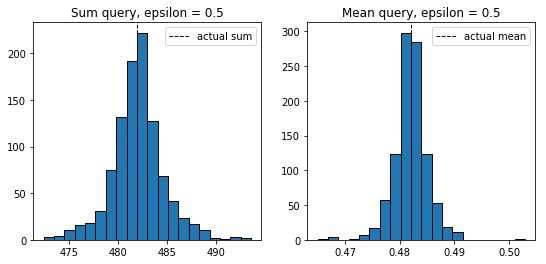

In [19]:
plot_distribution(epsilon=0.5)

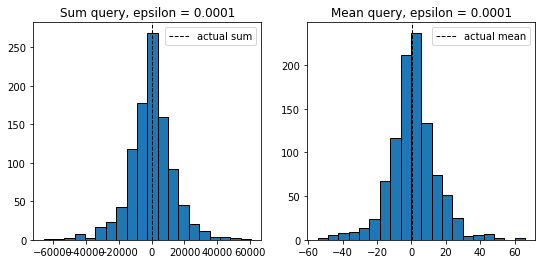

In [20]:
plot_distribution(epsilon=0.0001)

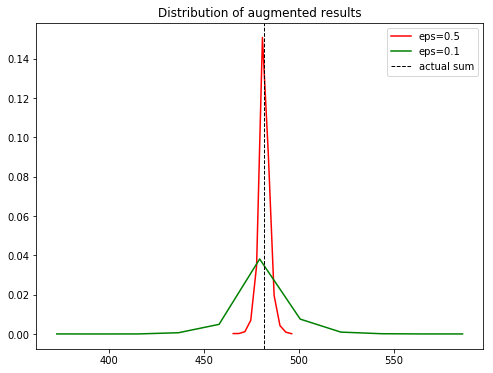

In [21]:
import scipy.stats as stats

dist_big_eps = query_repeat(db, sum_query, SUM_SENSITIVITY, 0.5, 10000)
dist_small_eps = query_repeat(db, sum_query, SUM_SENSITIVITY, 0.1, 10000)

plt.figure(figsize=(8, 6))
n, x = np.histogram(dist_big_eps)
plt.plot(x, stats.gaussian_kde(dist_big_eps)(x), 'r', label='eps=0.5')

n, x = np.histogram(dist_small_eps)
plt.plot(x, stats.gaussian_kde(dist_small_eps)(x), 'g' ,label='eps=0.1')
plt.axvline(sum_query(db), color='k', linestyle='dashed', linewidth=1, label='actual sum')
plt.legend()
plt.title("Distribution of augmented results")
# plt.savefig("relation3.png")
plt.show()

When **decrease epsilon**, a.k.a lower the privacy leakage, the **distribution** of augmented query **spread wider**, it means the **amount of noise added to the query is increased**. 